In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils.datapreparation import my_division_data
from utils.data_penobscot import penobscot_data_seg
from matplotlib.lines import Line2D

2024-05-23 07:33:29.241170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 07:33:29.241194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 07:33:29.241982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 07:33:29.246019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 07:33:29.697450: W tensorflow/compiler/tf2

## Modelo

In [2]:
# train_image,train_label, test_image, test_label, val_image, val_label=penobscot_data_seg(patch_h=1024, patch_w=192,stride_h=256, stride_w=64,train_ratio=0.7, test_ratio=0.2, val_ratio=0.1)
# model = tf.keras.models.load_model('/home/grad/ccomp/21/nuneslima/Seismic-Analysis/models/penobscot_100_22maio.keras')
# num_classes=8


In [3]:
train_image,train_label, test_image, test_label, val_image, val_label=my_division_data(shape=(992,192), stridetrain=(16,32), strideval=(16,32), stridetest=(16,32))
model = tf.keras.models.load_model('/home/grad/ccomp/21/nuneslima/Seismic-Analysis/models/parihaka_best100.keras')
num_classes=6


2024-05-23 07:33:41.441064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 07:33:41.457455: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 07:33:41.457603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
model.summary()

Model: "attunet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 992, 192, 1)]        0         []                            
                                                                                                  
 attunet_down0_0 (Conv2D)    (None, 992, 192, 16)         144       ['input_1[0][0]']             
                                                                                                  
 attunet_down0_0_bn (BatchN  (None, 992, 192, 16)         64        ['attunet_down0_0[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 attunet_down0_0_activation  (None, 992, 192, 16)         0         ['attunet_down0_0_bn[0][

## Funções

In [39]:
class GradCAMModel(tf.keras.Model):
    def __init__(self, model, conv_layer_name):
        super(GradCAMModel, self).__init__()
        self.segmentation_model = model
        self.extractor = tf.keras.Model(inputs=model.inputs, outputs=[model.get_layer(conv_layer_name).output])

    def call(self, x):
        feature_map = self.extractor(x)
        return feature_map

# Inicialize o modelo GradCAM
#Ativaco central: attunet_up1_conv_after_concat_3_activation
#primeira metade: attunet_down2_conv_3_activation (ruim demais)
#Ultima ativacao: attunet_up4_conv_after_concat_3_activation
#Ultima Camada: attunet_output
gradcam_model = GradCAMModel(model, 'attunet_output')

# Defina uma função para calcular os gradientes com relação ao mapa de ativação da classe
@tf.function
def compute_gradcam(image, class_idx):
    with tf.GradientTape() as tape:
        feature_map = gradcam_model(image)
        loss = tf.reduce_mean(feature_map[:, :, :, class_idx])

    grads = tape.gradient(loss, feature_map)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, feature_map), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    # Retorna o mapa de calor Grad-CAM como um tensor TensorFlow
    return heatmap


In [40]:
def heatmap_image(heatmap):
    heatmap = heatmap.squeeze()
    heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalizando o heatmap entre 0 e 1
    return heatmap_normalized

In [42]:
def visualize_prediction(image, true_mask, predicted_mask):
    true_mask=true_mask.squeeze()
    fig, axes = plt.subplots(1, 3, figsize=(5, 5), sharey=True)

    predicted_mask = np.argmax(predicted_mask[0], axis=-1)
    accuracy = np.mean(true_mask == predicted_mask) * 100
    class_colors = plt.cm.viridis(np.linspace(0, 1, num_classes))[:, :3]
    class_labels = [f'Classe {cls}' for cls in range(len(class_colors))]

    #Ground Truth
    overlay_true_mask = np.zeros(image.squeeze().shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_true_mask[true_mask == cls] = color
    axes[1].imshow(overlay_true_mask)
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    #Prediction
    overlay_predicted_mask = np.zeros(image.squeeze().shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_predicted_mask[predicted_mask == cls] = color
    axes[2].imshow(overlay_predicted_mask)
    axes[2].set_title(f"Prediction\nAccuracy: {accuracy:.2f}%")
    axes[2].axis('off')


    #Legend
    legend_axe = axes[0]
    legend_axe.axis('off')
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for color, label in zip(class_colors, class_labels)]
    legend_axe.legend(handles=legend_elements, loc='lower left')

In [29]:
def visualize_gradcam(image, true_mask, predicted_mask):
    true_mask=true_mask.squeeze()
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 5), sharey=True)

    predicted_mask = np.argmax(predicted_mask[0], axis=-1)
    class_colors = plt.cm.viridis(np.linspace(0, 1, 6))[:, :3]
    class_labels = [f'Classe {cls}' for cls in range(len(class_colors))]


    #Activations
    for target_class in range(0,num_classes):
        heatmap=compute_gradcam(image, target_class).numpy()
        heat_img=heatmap_image(heatmap)
        im = axes[target_class].imshow(heat_img)
        axes[target_class].set_title(f"Class {target_class}")
        axes[target_class].axis('off')
    
    fig.colorbar(im, ax=axes, orientation='horizontal', shrink=0.8,format='')

## Visualização

In [49]:
img_pos=2000
image=test_image[img_pos:img_pos+1,:,:]
label=test_label[img_pos:img_pos+1,:,:]
predicted_label=model.predict(image)

1/1 [==============================] - 0s 13ms/step


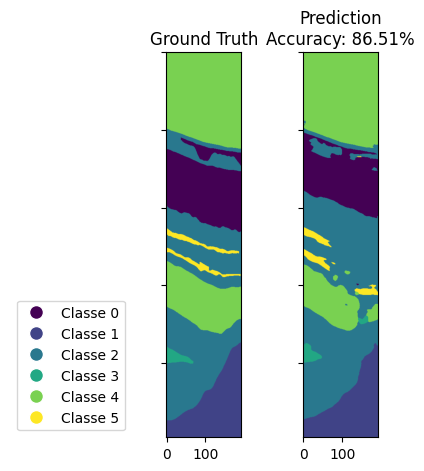

In [50]:
visualize_prediction(image,label,predicted_label)

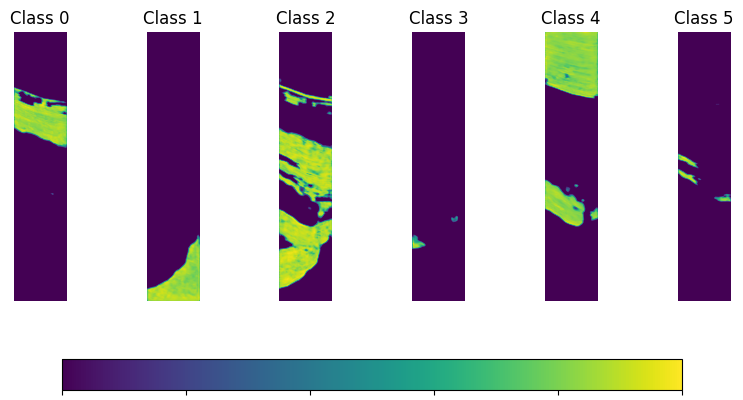

: 

In [51]:
visualize_gradcam(image,label,predicted_label)